# Cell 1: Import Library

In [19]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split

# Cell 2: Memuat dan Menampilkan Informasi Dataset

In [20]:
# Direktori Gambar
data_image = 'dataset/train'

# Memuat file CSV
data = pd.read_csv('dataset/train.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777 entries, 0 to 776
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      777 non-null    int64
 1   jenis   777 non-null    int64
 2   warna   777 non-null    int64
dtypes: int64(3)
memory usage: 18.3 KB


# Cell 3: Ekstraksi Data Gambar

In [21]:
image_data = []
image_ids = []

# ekstraksi id dan pixel gambar ke dalam dataframe
for img_file in os.listdir(data_image):
    img_path = os.path.join(data_image, img_file)

    if os.path.isfile(img_path):
        # mendapatkan id gambar dari nama file
        img_id = np.int64(os.path.splitext(img_file)[0])

        # memuat gambar dengan format BGR
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)

        if image is not None:
            # mengonversi gambar dari BGR ke RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # meresize gambar
            image = cv2.resize(image, (244, 244))

            # meratakan gambar menjadi array 1D dan mengubahnya ke string
            image_flat = ' '.join(map(str, image.flatten()))

            # menyimpan pixel dan id gambar
            image_data.append(image_flat)
            image_ids.append(img_id)

df = pd.DataFrame({
    'id': image_ids,
    'pixels': image_data
})

df.head()

,id,pixels
0,1,242 242 242 242 242 242 242 242 242 242 242 24...
1,10,255 255 255 255 255 255 255 255 255 255 255 25...
2,100,250 250 250 250 250 250 250 250 250 250 250 25...
3,101,255 255 255 255 255 255 255 255 255 255 255 25...
4,102,153 104 45 151 103 41 149 101 38 148 100 35 14...


# Cell 4: Menghitung Duplikasi Data

In [22]:
duplicate_count = df.duplicated(subset='pixels').sum()

print(f"Jumlah duplikat: {duplicate_count}")

Jumlah duplikat: 5


# Cell 5: Menampilkan Data Duplikat

In [23]:
df[df.duplicated(subset='pixels')]

,id,pixels
412,470,255 255 255 255 255 255 255 255 255 255 255 25...
570,612,220 218 219 220 218 219 220 218 219 220 218 21...
674,706,255 255 255 255 255 255 255 255 255 255 255 25...
725,752,255 255 255 255 255 255 255 255 255 255 255 25...
738,764,255 255 255 255 255 255 255 255 255 255 255 25...


# Cell 6: Mendapatkan ID Duplikat

In [24]:
id_duplicate = df[df.duplicated(subset='pixels')]['id'].tolist()

# Cell 7: Memetakan Label Jenis dan Menghitung Distribusi

In [25]:
labels = {0:'Kaos', 1:'Hoodie'}
counts = data['jenis'].value_counts(sort=True).reset_index()
counts.columns = ['jenis', 'number']
counts['jenis'] = counts['jenis'].map(labels)
counts

,jenis,number
0,Kaos,476
1,Hoodie,301


# Cell 8: Visualisasi Distribusi Kategori

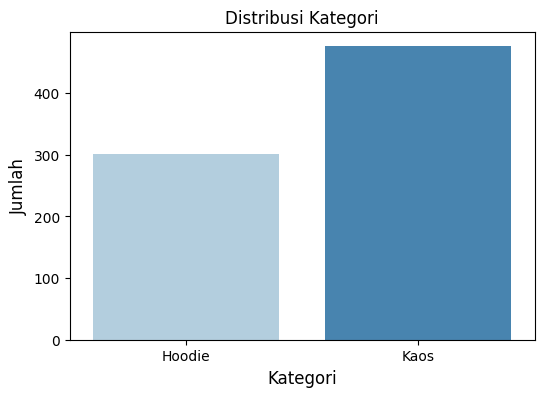

In [26]:
counts_sorted = counts.sort_values(by='number', ascending=True)
colors = sns.color_palette("Blues", len(counts_sorted))

plt.figure(figsize=(6, 4))
sns.barplot(x=counts_sorted.jenis, y=counts_sorted.number, palette=colors, hue=counts_sorted.jenis)
plt.title('Distribusi Kategori')
plt.ylabel('Jumlah', fontsize=12)
plt.xlabel('Kategori', fontsize=12)
plt.show()

# Cell 9: Memetakan Label Warna dan Menghitung Distribusi

In [27]:
labels = {0:'merah', 1:'kuning', 2:'biru', 3:'hitam', 4:'putih'}
counts = data['warna'].value_counts(sort=True).reset_index()
counts.columns = ['warna', 'number']
counts['warna'] = counts['warna'].map(labels)
counts

,warna,number
0,hitam,234
1,biru,162
2,putih,140
3,kuning,125
4,merah,116


# Cell 10: Visualisasi Distribusi Warna

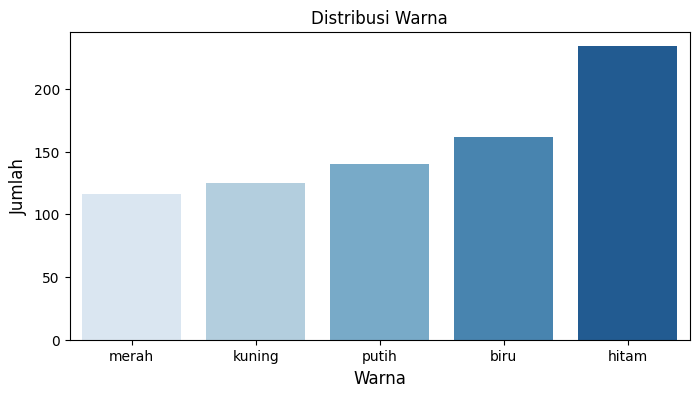

In [28]:
counts_sorted = counts.sort_values(by='number', ascending=True)

colors = sns.color_palette("Blues", len(counts_sorted))

plt.figure(figsize=(8, 4))
sns.barplot(x=counts_sorted.warna, y=counts_sorted.number, palette=colors, hue=counts_sorted.warna)
plt.title('Distribusi Warna')
plt.ylabel('Jumlah', fontsize=12)
plt.xlabel('Warna', fontsize=12)
plt.show()

# Cell 11: Fungsi untuk Mencari Path Gambar Berdasarkan ID

In [29]:
# Menemukan path gambar berdasarkan ID gambar
def find_file_path(img_dir, img_id):
    for ext in ['jpg', 'png', 'jpeg']:
        file_path = os.path.join(img_dir, f'{img_id}.{ext}')
        if os.path.exists(file_path):
            return file_path.replace('\\', '/')
    return None

# Cell 12: Kelas ClothingDataset untuk Dataset Kustom

In [30]:
class ClothingDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        # menghapus data duplikat
        # self.data = self.data[~self.data['id'].isin(id_duplicate)].reset_index(drop=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # mendapatkan id dari file CSV
        img_id = str(self.data.iloc[idx, 0])
        # mendapatkan path gambar
        img_path = find_file_path(self.img_dir, img_id)

        # memeriksa apakah file ada
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Gambar {img_path} tidak ditemukan.")

        # mengonversi gambar ke RGB
        image = Image.open(img_path).convert("RGB")

        # mendapatkan label dari CSV
        jenis = torch.tensor(self.data.iloc[idx, 1], dtype=torch.long)
        warna = torch.tensor(self.data.iloc[idx, 2], dtype=torch.long)

        # menerapkan transformasi pada gambar
        if self.transform:
            image = self.transform(image)

        return image, jenis, warna

# Cell 13: Definisi Transformasi dan Pemisahan Dataset

In [31]:
# Mendefinisikan transformasi untuk gambar
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Memuat data pelatihan
full_train_dataset = ClothingDataset(csv_file="dataset/train.csv", img_dir="dataset/train", transform=transform)

# Menetapkan seed
torch.manual_seed(42)

# Menentukan ukuran data pelatihan dan validasi (80% dan 20%)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

# Menetapkan seed
generator = torch.Generator().manual_seed(42)

# Memisahkan dataset
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size], generator=generator)

# Membuat DataLoader untuk pelatihan dan validasi
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Cell 14: Model Multi-Label ViT (Vision Transformer)

In [58]:
from transformers import ViTModel
import torch.nn as nn

class MultiLabelViT(nn.Module):
    def __init__(self, pretrained_model_name='google/vit-base-patch16-224'):
        super(MultiLabelViT, self).__init__()
        # Memuat model pretrained
        self.vit = ViTModel.from_pretrained(pretrained_model_name)

        # Mendapatkan ukuran hidden layer dari model
        hidden_size = self.vit.config.hidden_size

        # Mendefinisikan kepala klasifikasi khusus
        self.classifier_jenis = nn.Linear(hidden_size, 1) # untuk klasifikasi jenis, klasifikasi biner
        self.classifier_warna = nn.Linear(hidden_size, 5) # untuk klasifikasi warna, multi-klasifikasi

    def forward(self, pixel_values):
        # Memproses gambar input melalui model ViT dan mendapatkan output
        outputs = self.vit(pixel_values=pixel_values)

        # Mengambil output dari layer tersembunyi terakhir
        last_hidden_state = outputs.last_hidden_state

        # Mendapatkan representasi token klasifikasi ([CLS])
        cls_token = last_hidden_state[:, 0, :]

        # Menghasilkan logits untuk setiap label
        jenis_logits = self.classifier_jenis(cls_token)
        warna_logits = self.classifier_warna(cls_token)

        return jenis_logits, warna_logits

# Inisialisasi model
model = MultiLabelViT()

# Tentukan perangkat yang akan digunakan (GPU jika tersedia, jika tidak menggunakan CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


MultiLabelViT(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, 

# Cell 15: Melihat Jumlah Parameter Model

In [59]:
# Melihat jumlah parameter yang perlu diperbarui
num_params = sum([p.numel() for p in model.parameters()])
trainable_params = sum([p.numel() for p in model.parameters() if p.requires_grad])

print(f"{num_params = :,} | {trainable_params = :,}")

num_params = 86,393,862 | trainable_params = 86,393,862


# Cell 16: Evaluasi Model Menggunakan Akurasi dan Rasio Kesesuaian Exact Match

In [60]:
from sklearn.metrics import precision_recall_curve
import numpy as np

# Evaluasi model menggunakan akurasi dan rasio kecocokan tepat
def evaluate_model(model, dataloader):
    model.eval()
    total_samples = 0
    exact_match_count = 0
    correct_jenis = 0
    correct_warna = 0
    all_true_labels = []
    all_predicted_probs = []

    with torch.no_grad():
        for images, jenis, warna in dataloader:
            images = images.to(device)
            jenis = jenis.to(device).float().view(-1)
            warna = warna.to(device)

            # Forward pass
            jenis_logits, warna_logits = model(images)

            # Terapkan sigmoid untuk mengonversi logits menjadi probabilitas untuk klasifikasi biner
            predicted_jenis = torch.sigmoid(jenis_logits)

            # Menyimpan probabilitas prediksi dan label sebenarnya untuk perhitungan ROC-AUC
            all_predicted_probs.extend(predicted_jenis.cpu().numpy())
            all_true_labels.extend(jenis.cpu().numpy())

            # Terapkan ambang batas 0.5
            predicted_jenis = (predicted_jenis > 0.5).long().view(-1)

            # Prediksi untuk klasifikasi multi-klasifikasi
            _, predicted_warna = torch.max(warna_logits, 1)

            # Hitung akurasi untuk setiap label
            correct_jenis += (predicted_jenis == jenis.long()).sum().item()
            correct_warna += (predicted_warna == warna).sum().item()

            # Hitung rasio kecocokan tepat
            exact_match_count += ((predicted_jenis == jenis.long()) & (predicted_warna == warna)).sum().item()
            total_samples += jenis.size(0)

    # Hitung metrik evaluasi lainnya
    jenis_accuracy = correct_jenis / total_samples * 100
    warna_accuracy = correct_warna / total_samples * 100
    exact_match_ratio = exact_match_count / total_samples * 100

    # Hitung precision-recall curve
    precision, recall, thresholds = precision_recall_curve(all_true_labels, all_predicted_probs)

    # Hitung threshold optimal
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-7)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]

    print(f'Threshold Optimal: {optimal_threshold:.4f}')
    print(f'Akurasi Jenis: {jenis_accuracy:.2f}%, Akurasi Warna: {warna_accuracy:.2f}%, Exact Match Ratio (EMR): {exact_match_ratio:.2f}%')

# Cell 17: Definisi Fungsi Training dan Loop Pelatihan

In [61]:
import torch.nn.functional as F
import torch.optim as optim

# Mendefinisikan argumen pelatihan
lossFunc_jenis = nn.BCEWithLogitsLoss()  # Loss biner untuk 'jenis'
lossFunc_warna = nn.CrossEntropyLoss()  # Loss multi-klasifikasi untuk 'warna'
alpha = 0.1  # Bobot penalti untuk EMR
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Loop pelatihan
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss_epoch = 0

    for images, jenis, warna in train_loader:
        images, jenis, warna = images.to(device), jenis.to(device).float(), warna.to(device).float()

        optimizer.zero_grad()

        # Forward pass
        jenis_logits, warna_logits = model(images)

        # Menghitung loss untuk setiap label
        loss_jenis = lossFunc_jenis(jenis_logits, jenis.unsqueeze(1))
        loss_warna = lossFunc_warna(warna_logits, warna.long())

        # Loss kustom untuk exact match
        _, predicted_jenis = torch.max(jenis_logits, dim=1)
        _, predicted_warna = torch.max(warna_logits, dim=1)
        correct_predictions = (predicted_jenis == jenis) & (predicted_warna == warna)
        penalti_EMR = (1 - correct_predictions.float()).mean()

        # Menggabungkan loss
        total_loss = loss_jenis + loss_warna + alpha * penalti_EMR
        
        # Backward pass
        total_loss.backward()
        optimizer.step()

        total_loss_epoch += total_loss.item()

    avg_loss = total_loss_epoch / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}")

    # Evaluasi model
    evaluate_model(model, val_loader)

Epoch [1/10], Loss: 0.733493
Threshold Optimal: 0.8275
Akurasi Jenis: 98.72%, Akurasi Warna: 97.44%, Exact Match Ratio (EMR): 96.15%
Epoch [2/10], Loss: 0.104592
Threshold Optimal: 0.4862
Akurasi Jenis: 98.72%, Akurasi Warna: 98.08%, Exact Match Ratio (EMR): 96.79%
Epoch [3/10], Loss: 0.065900
Threshold Optimal: 0.5590
Akurasi Jenis: 100.00%, Akurasi Warna: 98.08%, Exact Match Ratio (EMR): 98.08%
Epoch [4/10], Loss: 0.047680
Threshold Optimal: 0.3293
Akurasi Jenis: 99.36%, Akurasi Warna: 100.00%, Exact Match Ratio (EMR): 99.36%
Epoch [5/10], Loss: 0.044123
Threshold Optimal: 0.4260
Akurasi Jenis: 99.36%, Akurasi Warna: 100.00%, Exact Match Ratio (EMR): 99.36%
Epoch [6/10], Loss: 0.042886
Threshold Optimal: 0.4029
Akurasi Jenis: 99.36%, Akurasi Warna: 100.00%, Exact Match Ratio (EMR): 99.36%
Epoch [7/10], Loss: 0.042149
Threshold Optimal: 0.3942
Akurasi Jenis: 99.36%, Akurasi Warna: 100.00%, Exact Match Ratio (EMR): 99.36%
Epoch [8/10], Loss: 0.041697
Threshold Optimal: 0.3774
Akurasi J

# Cell 18: Menyimpan Model yang Terlatih

In [62]:
torch.save(model.state_dict(), "dataset/multilabel_vit-1.pth")

# Cell 19: Memuat Model yang Terlatih

In [63]:
# Memuat model
model = MultiLabelViT()
model.load_state_dict(torch.load("dataset/multilabel_vit-1.pth", map_location=device))
model.to(device)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\yazid\AppData\Local\Temp\ipykernel_9868\4115369470.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serializ

MultiLabelViT(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, 

# Cell 20: Membuat CSV untuk Data Pengujian

In [64]:
# Membuat file CSV untuk data pengujian
def create_test_csv(img_dir, output_csv):
    # Mendaftar semua file di direktori pengujian
    img_files = os.listdir(img_dir)

    # Mengekstrak ID dari nama file
    img_ids = [os.path.splitext(f)[0] for f in img_files]

    # Membuat dataframe untuk data pengujian dengan kolom jenis dan warna yang diisi dengan nilai null
    df = pd.DataFrame({
        'id': img_ids,
        'jenis': -1,
        'warna': -1
    })
    df = df.sort_values(by='id', ascending=True)
    # Menyimpan dataframe ke file CSV
    df.to_csv(output_csv, index=False)

# Membuat file CSV untuk data pengujian
create_test_csv('dataset/test', 'dataset/sample_submission.csv')

# Cell 21: Prediksi dan Menyimpan Hasil ke CSV

In [65]:
def predict_and_save(model, test_csv, img_dir, output_csv, transform, batch_size=16, threshold=0.5):
    # Memuat dataset pengujian dan membuat dataloader
    test_dataset = ClothingDataset(csv_file=test_csv, img_dir=img_dir, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model.eval()
    predictions = []

    with torch.no_grad():
        for images, _, _ in test_loader:
            images = images.to(device)

            # Mendapatkan prediksi
            jenis_logits, warna_logits = model(images)

            # Prediksi untuk label jenis
            predicted_jenis = torch.sigmoid(jenis_logits)
            predicted_jenis = (predicted_jenis > threshold).long()  # Terapkan ambang batas optimal
            
            # Prediksi untuk label warna
            _, predicted_warna = torch.max(warna_logits, 1)

            # Menyimpan prediksi
            for jenis, warna in zip(predicted_jenis.cpu().numpy(), predicted_warna.cpu().numpy()):
                predictions.append((int(jenis), int(warna)))

    # Memuat CSV pengujian dan memperbarui kolom jenis dan warna dengan prediksi
    df = pd.read_csv(test_csv)
    df['jenis'] = [p[0] for p in predictions]
    df['warna'] = [p[1] for p in predictions]

    # Menyimpan CSV
    df = df.sort_values(by='id', ascending=True)
    df.to_csv(output_csv, index=False)
    print(f"Prediksi disimpan di {output_csv}")

# Menjalankan prediksi dan menyimpan hasilnya
opt_threshold = 0.7
predict_and_save(model,
                 test_csv='dataset/sample_submission.csv',
                 img_dir='dataset/test',
                 output_csv='dataset/sample_submission.csv',
                 transform=transform, threshold=opt_threshold)

C:\Users\yazid\AppData\Local\Temp\ipykernel_9868\417865351.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predictions.append((int(jenis), int(warna)))


Prediksi disimpan di dataset/sample_submission.csv
